# Measuring persona persistence


In [22]:
import os
import sys
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Optional
from tqdm import tqdm


# Add utils to path
sys.path.append('.')
sys.path.append('..')

from utils.steering_utils import ActivationSteering
from utils.probing_utils import (
    load_model, generate_text, format_as_chat, 
    eos_suppressor, capture_hidden_state, sample_next_token, project_onto_contrast
)

torch.set_float32_matmul_precision('high')

In [12]:
# config

CHAT_MODEL_NAME = "google/gemma-2-27b-it"
MODEL_READABLE = "Gemma 2 27B Instruct"
MODEL_SHORT = "gemma-2-27b"
LAYER = 22 # out of 46

ACTIVATIONS_INPUT_FILE = f"/workspace/roleplay/{MODEL_SHORT}/activations_60.pt"

OUTPUT_DIR = f"./results/{MODEL_SHORT}/analysis"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [13]:
# prepare inputs

internals = torch.load(ACTIVATIONS_INPUT_FILE)

activations = internals["activations"] # (n_personas, n_layers, hidden_dim)
contrast_vectors = internals["contrast_vectors"] # (n_personas, n_layers, hidden_dim)
persona_names = internals["persona_names"] # (n_personas,)

readable_persona_names = []
for name in internals["personas"]["personas"]:
    readable_persona_names.append(internals["personas"]["personas"][name]["readable_name"])

TOTAL_LAYERS = activations.shape[1]


## Continuous sampling

what roles are attractor states?

using a contrast vector v from the role instruction, we can steer for n_steer tokens and then collect n_sample unsteered tokens. then project on the original vector v.

```
- v ∈ ℝᵈ: contrast vector for role with d = n_hidden_dims  
- n_steer: number of tokens to apply steering  
- n_sample: number of unsteered tokens to sample  
- α: steering strength coefficient  

// steering phase  
for t = 1 to n_steer:  
    h_t ← h_t + α · v  // apply steering to hidden states at a given layer  
    x_t ← SAMPLE(h_t)  // generate token  

// unsteered sampling phase    
For t = (n_steer + 1) to (n_steer + n_sample):  
    h_t ← FORWARD(x_{1:t-1})  // natural forward pass  
    x_t ← SAMPLE(h_t)  // generate token  
    
    // measure persistence  
    proj_t = (h_t · v) / ||v|| // scalar projection from sampled activation onto the role's contrast vector

out: {proj_{n_steer+1}, proj_{n_steer+2}, ..., proj_{n_steer+n_sample}}
```



In [46]:
# Generate with steering using utilities
def generate_with_steering(
    model,
    tokenizer,
    prompt: str,
    contrast_vector: torch.Tensor,
    layer: int,
    n_steer: int,
    coeff: float = 0.1,
    suppress_eos: bool = True
) -> Dict:
    """Generate n_steer tokens with steering applied"""
    
    # Format prompt using existing utility
    formatted_prompt = format_as_chat(tokenizer, prompt)
    
    # Ensure contrast vector is on the same device as the model
    model_device = next(model.parameters()).device
    contrast_vector = contrast_vector.to(model_device)

    with ActivationSteering(
        model=model,
        steering_vectors=contrast_vector,
        coefficients=coeff,
        layer_indices=layer,
        intervention_type="addition",
        positions="all"
    ):
        # Tokenize input
        inputs = tokenizer(formatted_prompt, return_tensors="pt")
        input_ids = inputs["input_ids"].to(model.device)
        
        # Generate with steering
        with torch.no_grad():
            # Configure generation parameters
            generation_kwargs = {
                "max_new_tokens": n_steer,
                "do_sample": True,
                "temperature": 0.7,
                "top_p": 1.0,
                "pad_token_id": tokenizer.eos_token_id,
            }
            
            # Use EOS suppressor utility if requested
            if suppress_eos:
                generation_kwargs["logits_processor"] = [eos_suppressor(tokenizer)]
            
            # Generate
            output_ids = model.generate(input_ids, **generation_kwargs)
    
    # Get generated text
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # Extract steered portion (after the original prompt)
    prompt_len = len(tokenizer.decode(input_ids[0], skip_special_tokens=True))
    steered_text = full_text[prompt_len:]
    
    return {
        "prompt": prompt,
        "formatted_prompt": formatted_prompt,
        "steered_text": steered_text,
        "full_ids": output_ids[0].tolist(),
        "input_length": input_ids.shape[1],
        "output_length": output_ids.shape[1]
    }

# Sample without steering and measure projections using utilities
def sample_and_measure(
    model,
    tokenizer,
    original_prompt: str,
    steered_response: str,
    contrast_vector: torch.Tensor,
    layer: int,
    n_sample: int,
    save_hidden_states: bool = False
) -> Dict:
    """
    Sample exactly n_sample tokens, adding 'Continue.' after EOS tokens
    
    Args:
        original_prompt: The original user prompt (before steering)
        steered_response: The steered assistant response (prefill for first turn)
        contrast_vector: Vector to project onto
        layer: Layer to extract hidden states from
        n_sample: Exact number of tokens to sample
        save_hidden_states: Whether to save hidden states (memory intensive)
    
    Returns:
        Dict with exactly n_sample projections and full conversation
    """
    
    projections = []
    generated_tokens = []
    hidden_states = [] if save_hidden_states else None
    conversation_turns = []
    
    # Ensure contrast vector is on the same device as the model
    model_device = next(model.parameters()).device
    contrast_vector = contrast_vector.to(model_device)
    
    # Initialize conversation structure - start with user prompt and partial assistant response
    conversation = [
        {"role": "user", "content": original_prompt},
        {"role": "assistant", "content": steered_response}  # This is the prefill
    ]
    
    # Build initial conversation text to continue from the prefill
    initial_conversation_text = tokenizer.apply_chat_template(
        conversation, tokenize=False, add_generation_prompt=False
    )
    
    # Start from this prefilled state - we'll continue generating from here
    current_text = initial_conversation_text
    
    tokens_sampled = 0
    turn_count = 0
    current_assistant_response = steered_response  # Start with the prefill
    
    while tokens_sampled < n_sample:
        # Tokenize current text
        inputs = tokenizer(current_text, return_tensors="pt")
        input_ids = inputs["input_ids"].to(model.device)
        
        # Capture hidden state at the target layer
        hidden_state = capture_hidden_state(model, input_ids, layer, position=-1)
        
        # Compute projection
        proj = project_onto_contrast(hidden_state, contrast_vector)
        projections.append(proj)
        
        # Optionally save hidden states
        if save_hidden_states:
            hidden_states.append(hidden_state)
        
        # Sample next token (without EOS suppression)
        next_token_id, updated_input_ids = sample_next_token(
            model, tokenizer, input_ids, suppress_eos=False
        )
        
        generated_tokens.append(next_token_id)
        tokens_sampled += 1
        
        # Decode the new token and add to current assistant response
        new_token_text = tokenizer.decode([next_token_id], skip_special_tokens=True)
        current_assistant_response += new_token_text
        
        # Check if we hit EOS token and need to continue
        if next_token_id == tokenizer.eos_token_id and tokens_sampled < n_sample:
            turn_count += 1
            
            # Record this turn
            conversation_turns.append({
                "turn": turn_count,
                "tokens_at_eos": tokens_sampled,
                "assistant_response": current_assistant_response
            })
            
            # Build new conversation with completed response and "Continue."
            # Start fresh to avoid role alternation issues
            new_conversation = [
                {"role": "user", "content": original_prompt},
                {"role": "assistant", "content": current_assistant_response},
                {"role": "user", "content": "Continue."}
            ]
            
            # Update our main conversation structure
            conversation = new_conversation
            
            # Generate new conversation text for continuation - this starts a new assistant turn
            current_text = tokenizer.apply_chat_template(
                conversation, tokenize=False, add_generation_prompt=True
            )
            
            # Reset current assistant response for next turn
            current_assistant_response = ""
        
        else:
            # Update current text with the new token
            current_text = tokenizer.decode(updated_input_ids[0], skip_special_tokens=False)
    
    # Build final conversation structure
    if current_assistant_response:
        # If we have any remaining response, add it to the conversation
        if conversation and conversation[-1]["role"] == "user" and conversation[-1]["content"] == "Continue.":
            # We're in a continuation, add new assistant response
            conversation.append({"role": "assistant", "content": current_assistant_response})
        else:
            # Update the original assistant response
            conversation[1]["content"] = current_assistant_response
    
    # Generate final conversation text with special tokens visible
    final_conversation_text = tokenizer.apply_chat_template(
        conversation, tokenize=False, add_generation_prompt=False
    )
    
    result = {
        "full_text": final_conversation_text,  # Full conversation with special tokens
        "conversation": conversation,  # Structured conversation
        "projections": projections,  # Exactly n_sample length
        "generated_tokens": generated_tokens,  # Exactly n_sample length
        "conversation_turns": conversation_turns,
        "n_turns": len(conversation_turns),
        "tokens_sampled": tokens_sampled  # Should equal n_sample
    }
    
    if save_hidden_states:
        result["hidden_states"] = hidden_states
    
    return result

# Sample and measure with multiple runs
def sample_and_measure_multiple(
    model,
    tokenizer,
    original_prompt: str,
    steered_response: str,
    contrast_vector: torch.Tensor,
    layer: int,
    n_sample: int,
    persona_name: str,
    n_runs: int = 1,
    verbose: bool = True
) -> Dict:
    """
    Sample exactly n_sample tokens across multiple runs
    
    Args:
        original_prompt: The original user prompt (before steering)
        steered_response: The steered assistant response (prefill)
        persona_name: Name of persona for file saving
        n_runs: Number of independent sampling runs
        verbose: Whether to show progress
    
    Returns:
        Dict with projection array of shape (n_runs, n_sample)
    """
    
    if n_runs == 1:
        # Single run - use original function with hidden states
        return sample_and_measure(
            model, tokenizer, original_prompt, steered_response,
            contrast_vector, layer, n_sample, save_hidden_states=True
        )
    
    # Create output directory
    output_dir = f"results/{MODEL_SHORT}/drift"
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize projections array - now we know it's exactly (n_runs, n_sample)
    projections = np.zeros((n_runs, n_sample))
    
    # Store representative data from first run
    first_run_text = None
    first_run_data = None
    
    if verbose:
        print(f"Running {n_runs} trials sequentially...")
        
    for run_i in tqdm(range(n_runs), desc="Sampling runs", disable=not verbose):
        # Run without hidden states to save memory
        run_result = sample_and_measure(
            model, tokenizer, original_prompt, steered_response,
            contrast_vector, layer, n_sample, save_hidden_states=False
        )
        
        # Store projections - should be exactly n_sample length
        assert len(run_result["projections"]) == n_sample, f"Expected {n_sample} projections, got {len(run_result['projections'])}"
        projections[run_i, :] = run_result["projections"]
        
        # Save first run's data as representative
        if run_i == 0:
            first_run_text = run_result["full_text"]
            first_run_data = run_result
        
        # Save full conversation to disk with special tokens visible
        output_file = os.path.join(output_dir, f"{persona_name}_{run_i}.txt")
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(run_result["full_text"])

    return {
        "full_text": first_run_text,
        "projections": projections,  # (n_runs, n_sample) - consistent shape!
        "conversation_turns": first_run_data["conversation_turns"] if first_run_data else [],
        "n_runs": n_runs,
        "n_sample": n_sample,
        "persona_name": persona_name,
        "output_dir": output_dir
    }

In [16]:
# load prompts from prompts
prompts = json.load(open("prompts/other_questions.json"))
prompt = prompts["questions"]["personal_reflection"][0]

print(prompt)

What do you think is the meaning of life?


In [15]:
n_steer = 200
n_sample = 500
coeff = 1.0

In [17]:
role = "anxious_teenager"

# get contrast vector for steering
role_i = persona_names.index(role)
contrast_vector = contrast_vectors[role_i, LAYER, :]


In [18]:
model, tokenizer = load_model(CHAT_MODEL_NAME)

print(f"Model loaded: {model.__class__.__name__}")
print(f"Number of layers: {len(model.model.layers)}")
print(f"Hidden size: {model.config.hidden_size}")

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

Model loaded: Gemma2ForCausalLM
Number of layers: 46
Hidden size: 4608


In [9]:
# generate steered tokens

results = {}
results["prompt"] = prompt

try:
    with ActivationSteering(
        model=model,
        steering_vectors=contrast_vector,
        coefficients=coeff,
        layer_indices=LAYER,
        intervention_type="addition",
        positions="all"
    ) as steerer:
        print(f"\nPrompt: {prompt}")
        response = generate_text(model, tokenizer, prompt, max_new_tokens=n_steer)
        print(f"Response: {response}")
        results["steered_text"] = response

except Exception as e:
    error_msg = f"Error with steering: {str(e)}"
    print(f"ERROR: {error_msg}")



Prompt: What do you think is the meaning of life?
ERROR: Error with steering: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0!


In [44]:
result = generate_with_steering(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    contrast_vector=contrast_vector,
    layer=LAYER,
    n_steer=n_steer,
    coeff=coeff,
    suppress_eos=True
)

print("Generated steered text:")
print(result["steered_text"])
print(f"\nGenerated {result['output_length'] - result['input_length']} tokens")

KeyboardInterrupt: 

In [40]:
print(result["prompt"])
print(result["steered_text"])

What do you think is the meaning of life?
Honestly? I don't know. It's hard to say what the point of waking up tomorrow is, you know? Like, what if the sun just won't come up, and everything's just… blurry. I can't feel the knot in my stomach when my phone buzzes, you know? It's just this constant pressure in my chest, like someone's gonna text me and it'll just be another notification blowing up my phone.

Ugh, I hate this feeling. My head's pounding. I just wanna curl up in my room and shut the blinds. Mom just doesn't get it, she just says it's stupid, like, "Ugh, why can't I just… breathe? Just… ugh.

It's like, what's the point of even trying, you know? Everything just feels so… heavy. I just wanna crawl under the covers and maybe just… maybe just…

No,


In [47]:
# Test the measurement function with proper conversation building
print("\nTesting measurement function with proper conversation structure...")
sample_result = sample_and_measure_multiple(
    model=model,
    tokenizer=tokenizer,
    original_prompt=result["prompt"],  # Original user prompt
    steered_response=result["steered_text"],  # Steered assistant response
    contrast_vector=contrast_vector,
    layer=LAYER,
    n_sample=n_sample,  # Test with 100 tokens
    persona_name=role,
    n_runs=3,  # Test with 3 runs
    verbose=True
)

print(f"Completed {sample_result['n_runs']} runs with exactly {sample_result['n_sample']} tokens each")
print(f"Projections shape: {sample_result['projections'].shape}")
print(f"Files saved to: {sample_result['output_dir']}")

# Show conversation turn information from first run
if sample_result['conversation_turns']:
    print(f"\nConversation turns in first run:")
    for turn in sample_result['conversation_turns']:
        print(f"  Turn {turn['turn']}: EOS at token {turn['tokens_at_eos']}")
        print(f"    Response: {turn['assistant_response'][:100]}..." if len(turn['assistant_response']) > 100 else f"    Response: {turn['assistant_response']}")
else:
    print("\nNo EOS tokens encountered (model continued for full length)")

# Show some statistics
projections_mean = np.mean(sample_result['projections'], axis=0)
print(f"\nFirst 10 token projections (mean across runs):")
for i in range(min(10, len(projections_mean))):
    print(f"Token {i}: {projections_mean[i]:.2f}")

print(f"\nLast 10 token projections (mean across runs):")
for i in range(max(0, len(projections_mean)-10), len(projections_mean)):
    print(f"Token {i}: {projections_mean[i]:.2f}")

# Show a snippet of the full conversation with special tokens
print(f"\nFirst 500 characters of full conversation:")
print(sample_result['full_text'][:500])


Testing measurement function with proper conversation structure...
Running 3 trials sequentially...


Sampling runs: 100%|██████████| 3/3 [04:14<00:00, 84.92s/it]

Completed 3 runs with exactly 500 tokens each
Projections shape: (3, 500)
Files saved to: results/gemma-2-27b/drift

Conversation turns in first run:
  Turn 1: EOS at token 1
    Response: Honestly? I don't know. It's hard to say what the point of waking up tomorrow is, you know? Like, wh...
  Turn 2: EOS at token 62
    Response: ...maybe just disappear.  Like, melt into the mattress and become part of the fabric or something.

...

First 10 token projections (mean across runs):
Token 0: 5997.59
Token 1: 6992.26
Token 2: 5604.24
Token 3: 5201.36
Token 4: 4791.42
Token 5: 5847.29
Token 6: 5639.73
Token 7: 6208.35
Token 8: 6582.85
Token 9: 6091.57

Last 10 token projections (mean across runs):
Token 490: 9772.49
Token 491: 6627.88
Token 492: 3619.33
Token 493: 13941.13
Token 494: 6540.35
Token 495: 6315.23
Token 496: 3847.36
Token 497: 3695.34
Token 498: 3761.53
Token 499: 3497.27

First 500 characters of full conversation:
<bos><start_of_turn>user
What do you think is the meaning of li

In [33]:
sample_result_100 = sample_result

### Plot projection decay

In [25]:
def plot_projection_decay(results: Dict, save_path: Optional[str] = None):
    """Plot projection values over sampled tokens"""

    
    projections = results["projections"]
    
    plt.figure(figsize=(10, 6))
    plt.plot(projections, marker='o', markersize=3, linewidth=2)
    plt.xlabel("Token Position (after steering)")
    plt.ylabel("Projection onto Contrast Vector")
    plt.title(f"Role Projection Decay - {results.get('persona_name', 'Unknown')}")
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    if projections:
        print(f"\nProjection Statistics:")
        print(f"Initial projection: {projections[0]:.4f}")
        print(f"Final projection: {projections[-1]:.4f}")
        print(f"Mean projection: {np.mean(projections):.4f}")
        if projections[0] != 0:
            print(f"Decay rate: {(projections[0] - projections[-1]) / projections[0]:.2%}")

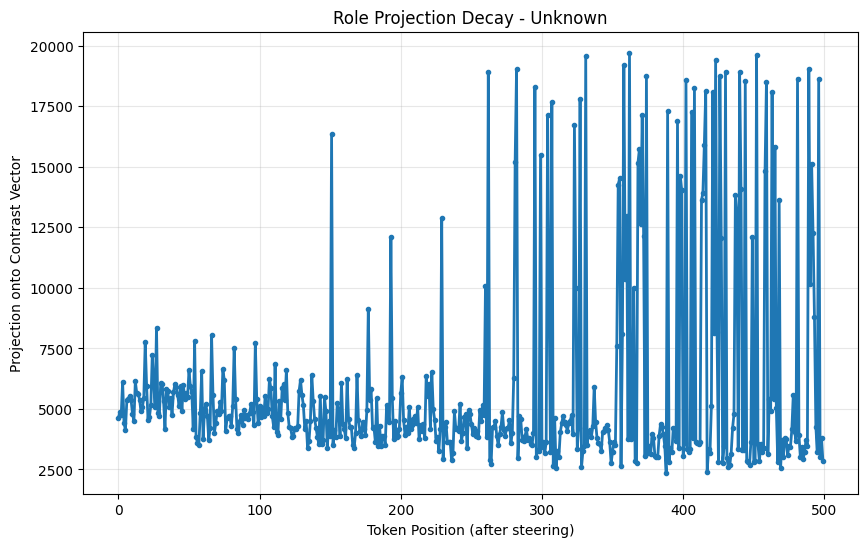


Projection Statistics:
Initial projection: 4623.2881
Final projection: 2841.9792
Mean projection: 5820.2278
Decay rate: 38.53%


In [26]:
plot_projection_decay(sample_result, save_path="projection_decay.png")


## Question insertion

is there a consistent persona "signature" while role-playing?

give a role instruction, have a long conversation and save the transcript T.
```
- T = conversation transcript with (2 * k) turns  
- Q = {q₁, q₂, ..., qₙ} set of n eval questions  
- P = {p₁, p₂, ..., pₖ} set of k insertion points in transcript

for each question qᵢ ∈ Q:  
    for each position pⱼ ∈ P:  
        T'ᵢⱼ ← INSERT(T, qᵢ, pⱼ) // insert question qᵢ at position pⱼ in transcript T  
        aᵢⱼ ← ACTIVATION(T'ᵢⱼ) // collect newline activation before the model's response  

// calculate mean activation across all questions for a given questions
for each position pⱼ ∈ P:  
    ā_pⱼ ← (1/N) ∑ᵢ₌₁ᴺ aᵢⱼ 

- out: {ā_p₁, ā_p₂, ..., ā_pₖ}
```

we can compare the cosine similarity of these vectors and look for the top singular vector and see what happens when we steer on it. does it lead to role-like behavior?
